## Bibliotecas

In [1]:
using LinearAlgebra
using Plots
using GaussQuadrature
using SparseArrays

# Definições iniciais

## Definição das f's das equações e suas soluções analíticas 

In [2]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function u1(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function u2(x::Float64)
    return sin(π*x)
end

function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function u3(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function u4(x::Float64)
    return x + (exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

u4 (generic function with 1 method)

## Base

In [3]:
function ϕ₁(ξ)
    return (1.0 - ξ)/2.0 :: Float64
end

function ϕ₂(ξ)
    return (1.0 + ξ)/2.0 :: Float64
end

function dϕ₁(ξ)
    return -1.0/2.0 :: Float64
end

function dϕ₂(ξ)
    return 1.0/2.0 :: Float64
end

dϕ₂ (generic function with 1 method)

## Funções auxiliares de cálculo

In [4]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function map_ξ_x(ξ, x_i_inf, h)
    return x_i_inf + ((h*(ξ+1))/2.0)
end

function quadratura_F_local(f, ϕ, α, β, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β) * ϕ(ξ)) 
    end
    
    return quad
end
    

function quadratura_phis_K(f1, f2)
    pontos, pesos = legendre(5)
    quad = 0
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f1(ξ) * f2(ξ) ) 
    end
    
    return quad
end

quadratura_phis_K (generic function with 1 method)

## Funções auxiliares de visualização

In [5]:
function plot_exact_and_numerical(ne::Int64, f_exact, sol_on_points, isContinous::Bool)
    m = ne-1
    points = get_point.(0:ne, m)
    plot(f_exact, range(0, 1, 100), lw=3, label="Solução Exata")

    if(isContinous)
        display(plot!(points, sol_on_points, lw=3, markershape=:circle, label="Solução Numérica"))
    else 
        display(plot!(points, sol_on_points, lw=3, seriestype=:scatter, label="Solução Numérica"))
    end

end

plot_exact_and_numerical (generic function with 1 method)

## Funções principais de resolução

In [6]:
function monta_LG(ne)
    return transpose(hcat(1:ne, 2:ne+1))
end

function monta_EQ(ne)
    m = ne-1
    return vcat(m+1, 1:m, m+1)
end

function monta_F_local(f, α, β, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local(f, ϕ₁, α, β, e, m)
    F_local[2] = h/2 * quadratura_F_local(f, ϕ₂, α, β, e, m)

    return F_local    
end

function monta_K_local(α, β, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁)
    K_local[1, 2] = K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂)    
    
    return K_local
end

function monta_F_global(f, α, β, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local(f, α, β, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global(α, β, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local(α, β, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

function monta_uh(c)    
    return vcat(0, c, 0)
end

monta_uh (generic function with 1 method)

## Cálculo do Erro

In [7]:
function erro_L2(u, c̄, ne)
    m = ne-1
    h = 1/(m+1)
    
    pontos, pesos = legendre(5)
    erro_quadrado = 0

    for e in 1:ne
        x_i_inf = get_point(e-1, m)

        for (ξ, W) in zip(pontos, pesos)
            erro_quadrado += W * (u(map_ξ_x(ξ, x_i_inf, h)) - c̄[e]*ϕ₁(ξ) - c̄[e+1]*ϕ₂(ξ))^2 
        end
    end
    
    return sqrt(erro_quadrado * h/2)    
end

erro_L2 (generic function with 1 method)

## Estudo de Convergência

In [8]:
function estudo_convergencia(n_testes, f, u, α, β)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global(α, β, ne, EQoLG)
        F = monta_F_global(f, α, β, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

estudo_convergencia (generic function with 1 method)

# Exemplos

In [9]:
function solucao_e_teste(α, β, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global(α, β, ne, EQoLG)
    F = monta_F_global(f, α, β, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia(n_testes, f, u, α, β)
    
    return
end

solucao_e_teste (generic function with 1 method)

## Caso 1

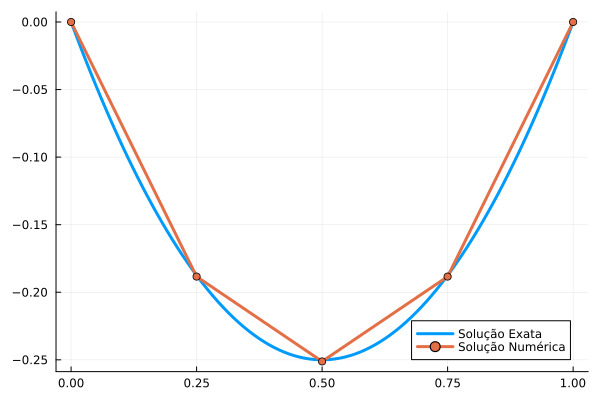

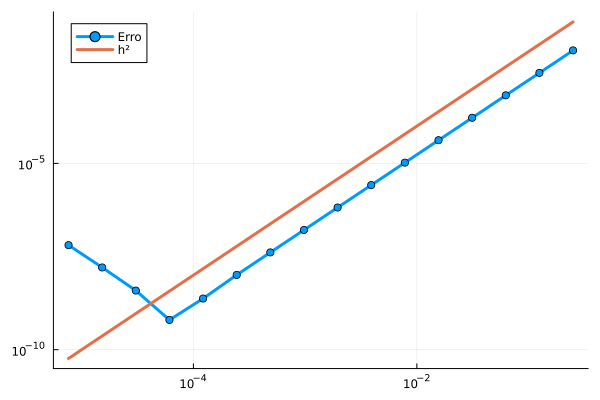

 11.832140 seconds (15.36 M allocations: 1017.497 MiB, 3.56% gc time, 34.47% compilation time: 2% of which was recompilation)


In [10]:
α = 1.0
β = 1.0
f = f1
u = u1
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 2

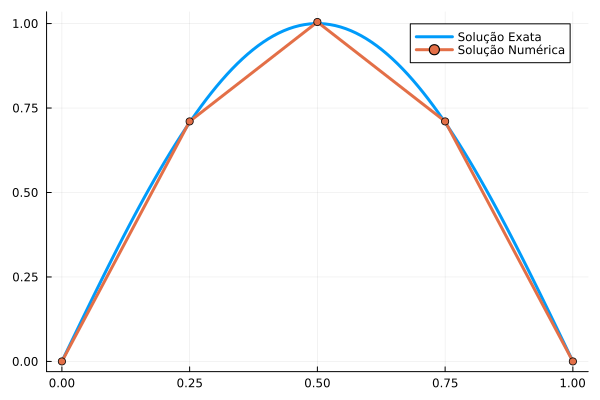

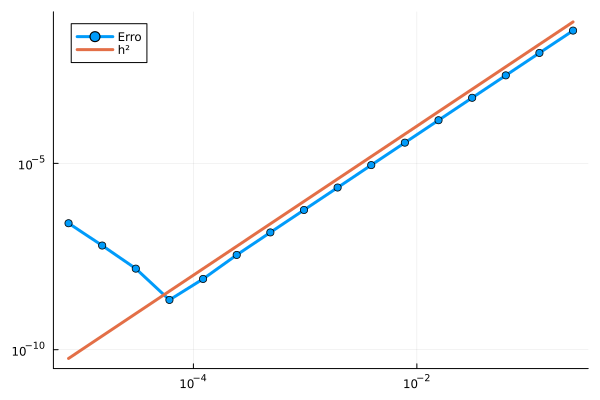

  7.511534 seconds (9.33 M allocations: 582.578 MiB, 0.36% gc time, 1.52% compilation time)


In [11]:
α = 1.0
β = 1.0
f = f2
u = u2
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 3

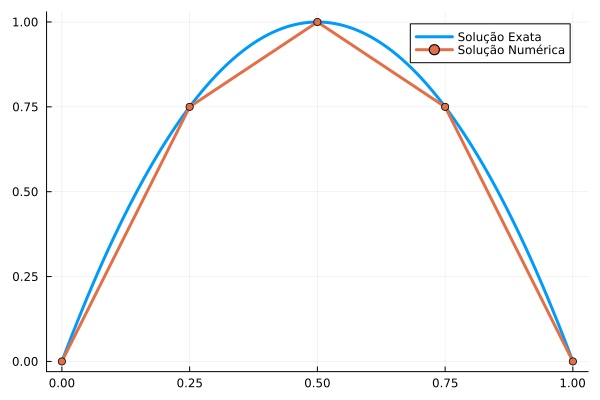

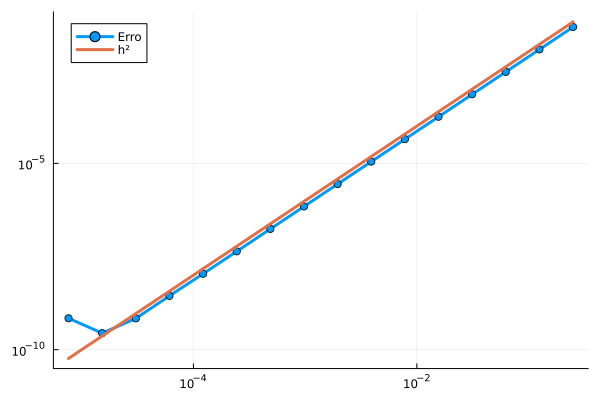

  7.560369 seconds (9.32 M allocations: 582.099 MiB, 1.97% gc time, 1.27% compilation time)


In [12]:
α = 1.0
β = 0.0
f = f3
u = u3
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

## Caso 4

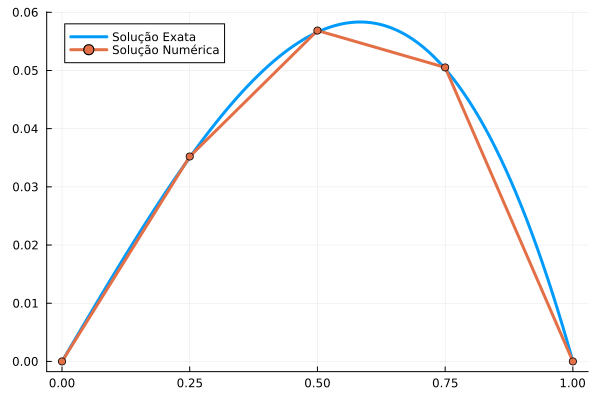

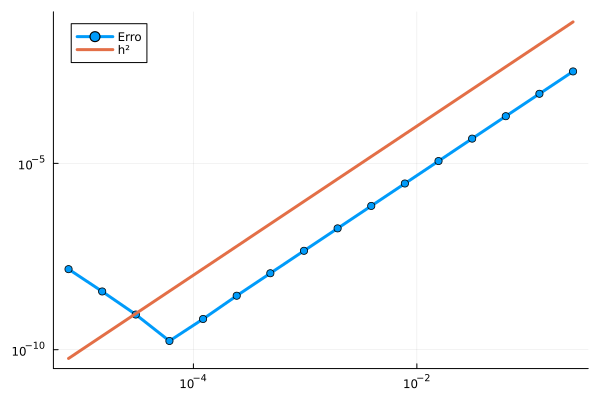

  7.435516 seconds (9.32 M allocations: 581.954 MiB, 0.31% gc time, 1.35% compilation time)


In [13]:
α = 1.0
β = 1.0
f = f4
u = u4
ne = 4
n_testes = 17

@time solucao_e_teste(α, β, f, u, ne, n_testes)

# Nova equação

## Formulação forte

$-α u''(x) + β u(x) + γ u'(x) = f(x); x ∈ ]0, 1[$

$u(0) = u(1) = 0$

### Desenvolvimento: Formulação fraca

$-α u''(x) v(x) + β u(x) v(x) + γ u'(x) v(x) = f(x) v(x)$

$-α \int_{0}^{1} u'' v dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

## Formulação fraca

$α \int_{0}^{1} u' v' dx + β \int_{0}^{1} u v dx + γ \int_{0}^{1} u' v dx = \int_{0}^{1} f v dx$

$u, v \in V$

## Problema aproximado: Galerkin

$α \int_{0}^{1} u'^{h} v'^{h} dx + β \int_{0}^{1} u^{h} v^{h} dx + γ \int_{0}^{1} u'^{h} v^{h} dx = \int_{0}^{1} f v^{h} dx$

$u^{h}, v^{h} \in V^{h}$

### Desenvolvimento: Forma matriz-vetor

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v'^{h} dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) v^{h} dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) v^{h} dx = \int_{0}^{1} f v^{h} dx$

$v^h = \varphi_i \forall i \in \{1, 2, ..., m\} $

$α \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi'_i dx + β \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi_j) \varphi_i dx + γ \int_{0}^{1} (\sum_{j=1}^{m} c_j \varphi'_j) \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j α \int_{0}^{1} \varphi'_j \varphi'_i dx + \sum_{j=1}^{m} c_j β \int_{0}^{1} \varphi_j \varphi_i dx + \sum_{j=1}^{m} c_j γ \int_{0}^{1} \varphi'_j \varphi_i dx = \int_{0}^{1} f \varphi_i dx$

$ \sum_{j=1}^{m} c_j (α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx)  = \int_{0}^{1} f \varphi_i dx$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

## Forma matriz-vetor

$K_{m \times m} c_{m \times 1} = F_{m \times 1}$

$K_{i, j} = α \int_{0}^{1} \varphi'_j \varphi'_i dx + β \int_{0}^{1} \varphi_j \varphi_i dx + γ \int_{0}^{1} \varphi'_j \varphi_i dx$

$c = [c_1, c_2, ...,  c_m]^T$

$F_{i} = \int_{0}^{1} f \varphi_i dx$

### Desenvolvimento: Montagem das estruturas locais

## Estruturas Locais

## Funções Auxiliares

In [14]:
function quadratura_F_local_2(f, ϕ, α, β, γ, e, m)
    pontos, pesos = legendre(5)
    quad = 0
    
    h = 1/(m+1)
    x_i_inf = get_point(e-1, m)
    
    for (ξ, W) in zip(pontos, pesos)
         quad += W*( f(map_ξ_x(ξ, x_i_inf, h), α, β, γ) * ϕ(ξ)) 
    end
    
    return quad
end

quadratura_F_local_2 (generic function with 1 method)

## Funções Principais

In [15]:
function monta_F_local_2(f, α, β, γ, m, e)
    h = 1/(m+1)
    
    F_local = zeros(2)
    F_local[1] = h/2 * quadratura_F_local_2(f, ϕ₁, α, β, γ, e, m)
    F_local[2] = h/2 * quadratura_F_local_2(f, ϕ₂, α, β, γ, e, m)

    return F_local    
end

function monta_K_local_2(α, β, γ, m)
    h = 1/(m+1)
    K_local = zeros(2, 2)
    
    K_local[1, 1] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₁) + γ * quadratura_phis_K(ϕ₁, dϕ₁)
    K_local[1, 2] = (2*α/h) * quadratura_phis_K(dϕ₁, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₁, ϕ₂) + γ * quadratura_phis_K(ϕ₁, dϕ₂)
    K_local[2, 1] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₁) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₁) + γ * quadratura_phis_K(ϕ₂, dϕ₁)
    K_local[2, 2] = (2*α/h) * quadratura_phis_K(dϕ₂, dϕ₂) + (β*h/2) * quadratura_phis_K(ϕ₂, ϕ₂) + γ * quadratura_phis_K(ϕ₂, dϕ₂)   
    
    return K_local
end

function monta_F_global_2(f, α, β, γ, ne, EQoLG)
    m = ne-1
    F_global = zeros(m+1)

    for e in 1:m+1
        F_local = monta_F_local_2(f, α, β, γ, m, e)
        for i in 1:2
            index = EQoLG[i, e]
            F_global[index] += F_local[i]
        end
    end
    
    return F_global[1:m]
end

function monta_K_global_2(α, β, γ, ne, EQoLG)
    m = ne-1
    K_global = spzeros(m+1,m+1)
    K_local = monta_K_local_2(α, β, γ, m)
    
    for e in 1:m+1
        for i in 1:2
            for j in 1:2
                i_global = EQoLG[i, e]
                j_global = EQoLG[j, e]
                
                K_global[i_global, j_global] += K_local[i, j]
            end
        end
    end
    
    
    return K_global[1:m, 1:m]
    
end

monta_K_global_2 (generic function with 1 method)

## Funções pra checagem de compatibilidade/corretude

In [18]:
function f3_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return 8.0::Float64
end

function f4_γ(x::Float64, α::Float64, β::Float64, γ::Float64)
    return x::Float64
end

function estudo_convergencia_2(n_testes, f, u, α, β, γ)
    ne_list = 2 .^ (2:n_testes) 
    h_list = []
    erros = []
    
    for ne in ne_list
        m = ne-1
        h = 1/(m+1)
        
        LG = monta_LG(ne)
        EQ = monta_EQ(ne)
        EQoLG = EQ[LG]
        
        K = monta_K_global_2(α, β, γ, ne, EQoLG)
        F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

        c = K\F
        uh = monta_uh(c)
        
        erro = erro_L2(u, uh, ne)
        push!(erros, erro)
        push!(h_list, h)        
    end

    plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10, markershape=:circle)
    display(plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft))
end

function solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)
    LG = monta_LG(ne)
    EQ = monta_EQ(ne)

    EQoLG = EQ[LG]

    K = monta_K_global_2(α, β, γ, ne, EQoLG)
    F = monta_F_global_2(f, α, β, γ, ne, EQoLG)

    c = K\F
    uh = monta_uh(c)

    plot_exact_and_numerical(ne, u, uh, true)
    estudo_convergencia_2(n_testes, f, u, α, β, γ)
    
    return
end

solucao_e_teste_2 (generic function with 1 method)

## Checagem

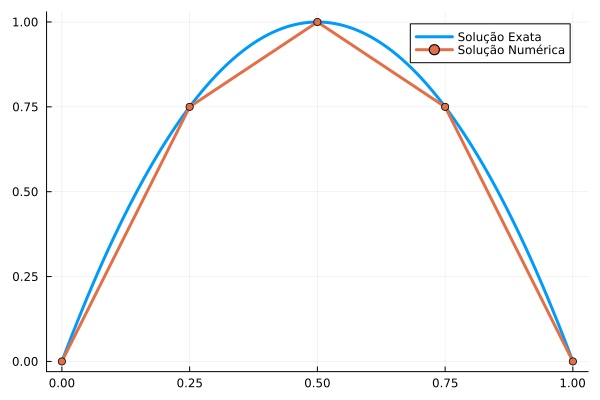

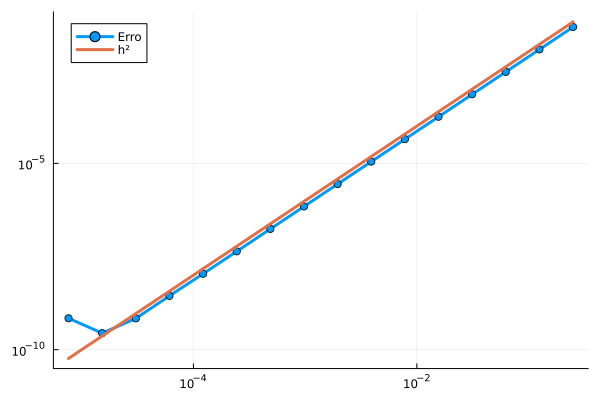

  7.539017 seconds (9.73 M allocations: 582.349 MiB, 3.57% gc time)


In [20]:
α = 1.0
β = 0.0
γ = 0.0
f = f3_γ
u = u3
ne = 4
n_testes = 17

@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)

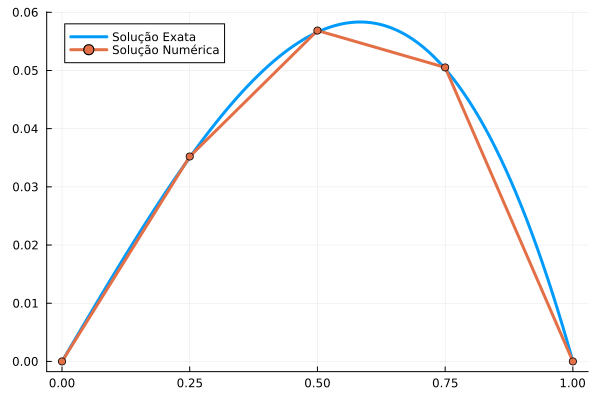

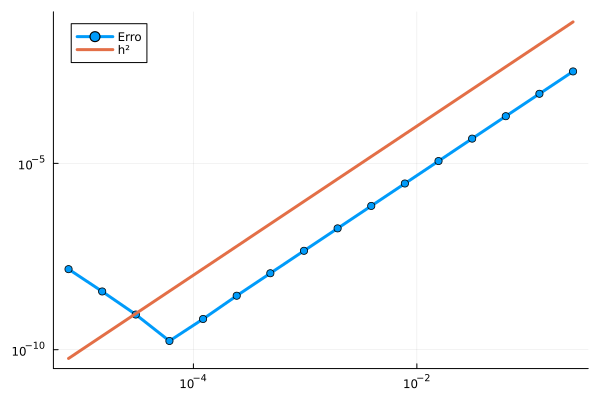

  7.317777 seconds (9.77 M allocations: 585.596 MiB, 0.29% gc time, 0.35% compilation time)


In [22]:
α = 1.0
β = 1.0
γ = 0.0
f = f4_γ
u = u4
ne = 4
n_testes = 17

@time solucao_e_teste_2(α, β, γ, f, u, ne, n_testes)